### Weighted Linear Regression  
We will now consider dataset, ds5. The only difference is that is that x^{i} is one dimensional
- implement locally weighted linear regression, using the normal equations derived in part a. We are also going to use the weights formula: 
$$
w^{(i)} = \exp\left( -\frac{\|x^{(i)} - x\|_2^2}{2\tau^2} \right).
$$


In [3]:
## Weighted Linear regresssion 
import matplotlib.pyplot as plt
import numpy as np
import util

from linear_model import LinearModel

def plot(x, y_label, y_pred, title):
    plt.figure()
    plt.plot(x[:,-1], y_label, 'bx', label='label')
    plt.plot(x[:,-1], y_pred, 'ro', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

def main(tau, train_path, eval_path):
    """Problem 5(b): Locally weighted regression (LWR)

    Args:
        tau: Bandwidth parameter for LWR.
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
    """
    # Load training set
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)
    x_eval, y_eval = util.load_dataset(eval_path, add_intercept=True)
    model = LocallyWeightedLinearRegression(tau=tau)
    model.fit(x_train, y_train)
    predicts = model.predict(x_eval)
    plot(x_eval, y_eval, predicts, f"tau = {tau}")


class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.
        This is because we don't train to fit the model once for a global model, instead
        we train it for each query at test time 
        """
        self.x = x
        self.y = y
        

    def predict(self, x):
        """Make predictions given inputs x.
        """
        predicts = []
        for idx, pivot in enumerate(x):
            # create the W matrix 
            weights_lst_this_run = []
            for idi, xi in enumerate(self.x):
                # the training set, calculate w 
                wi = np.exp(-(np.square(np.linalg.norm(xi - pivot))) / (2 * self.tau ** 2))
                weights_lst_this_run.append(wi)
            # at the end, we turn into a vector to get a W diagonal matrix
            weights_this_run_ndarr = np.array(weights_lst_this_run)
            weights_matrix_this_run = np.diag(weights_this_run_ndarr)
            # we calculate theta
            inv = np.linalg.inv(np.dot(np.dot(self.x.T, weights_matrix_this_run), self.x))
            theta_this_run = np.dot(inv, np.dot(np.dot(self.x.T, weights_matrix_this_run), self.y))
            # last line could be wrong, check if inv should be like this 
            # predict, using pivot and theta 
            pred = np.dot(theta_this_run, pivot)
            predicts.append(pred)
        return np.array(predicts)
            


            
                
            


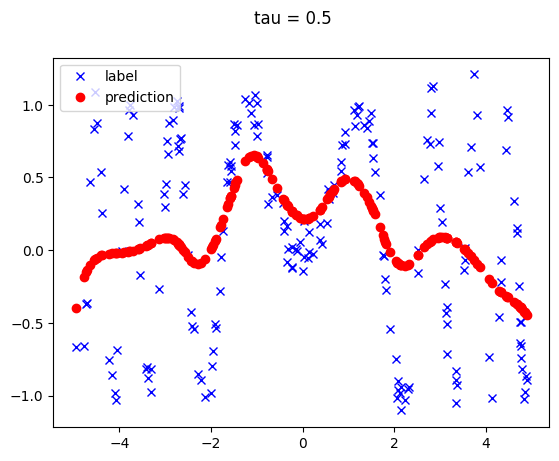

In [4]:
train_path = '../data/ds5_train.csv'
eval_path = '../data/ds5_valid.csv'
test_path = '../data/ds5_test.csv' 

main(0.5, train_path=train_path, eval_path=eval_path)

## 5b
The model seems to be underfitting. It seems to move towards the areas of the curve, but not enough. 

## 5c
We will now tune the hyperparameter $\tau$. Find the mse value of your model on the validation set for each of the values of $\tau$ specified in the code . For each $\tau$, plot your model's predictions on the validation set in the format described in 5b. Report the value of $\tau$ which achieves the lowest mse on the valid set, and report the mse on the test split using this value. 

In [15]:
def MSE(pred_labels, true_labels):
    '''
    finds the mean squared error based on the pred labels and true labels 
    '''
    if pred_labels.shape != true_labels.shape:
        raise Exception("Shapes don't match")

    return np.mean(np.square(true_labels - pred_labels))

def find_best_tau(train_path, valid_path, test_path):
    """Problem 5(b): Tune the bandwidth paramater tau for LWR.

    Args:
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
    """
    # Load training set
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)
    x_eval, y_eval = util.load_dataset(valid_path, add_intercept=True)
    x_test, y_test = util.load_dataset(test_path, add_intercept=True)

    ## so find the best tau based on the validation set, 
    best_tau = -1
    best_MSE = float('inf')
    taus = np.arange(0.01, 1.01, 0.01) 
    for tau in taus:
        model = LocallyWeightedLinearRegression(tau)
        model.fit(x_train, y_train)
        predicts = model.predict(x_eval)
        # get MSE based on y_eval
        mse = MSE(predicts, y_eval)
        if mse < best_MSE:
            best_MSE = mse
            best_tau = tau
    # now that we have best tau, plot it again 
    model = LocallyWeightedLinearRegression(best_tau)
    model.fit(x_train, y_train)
    best_tau_predicts = model.predict(x_eval)
    print(f"The best tau is {best_tau}")
    plot(x_eval, y_eval, best_tau_predicts, f"Best tau: tau = {best_tau} | Validation Set")

    best_tau_test_predicts = model.predict(x_test)
    plot(x_test, y_test, best_tau_test_predicts, f"Best tau: tau = {best_tau} | Test Set")
    # print MSE
    print(f"MSE for validation set: {MSE(best_tau_predicts, y_eval)}")
    print(f"MSE for test set: {MSE(best_tau_test_predicts, y_test)}")


The best tau is 0.05
MSE for validation set: 0.012400076150468715
MSE for test set: 0.016990143386877793


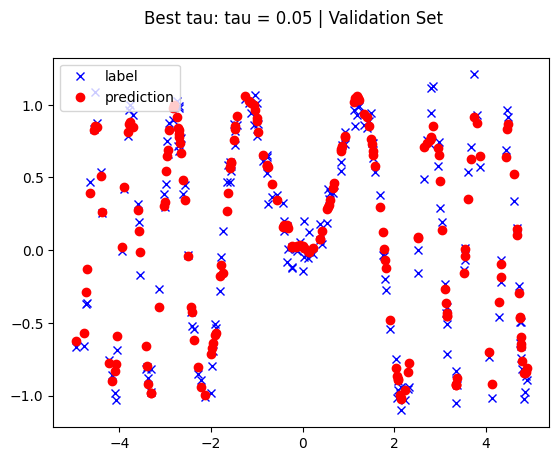

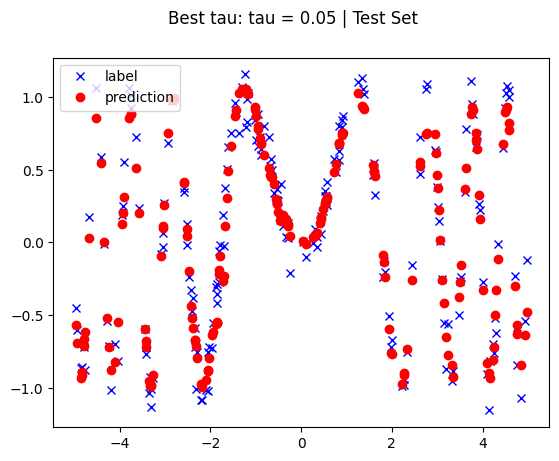

In [16]:
find_best_tau(train_path, eval_path, test_path)

### 5C 
The best $\tau$ is 0.05, achieving an MSE of 0.012 for the validation set, and 0.017 for the test set